In [1]:
#드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from types import SimpleNamespace
from sklearn.preprocessing import MinMaxScaler
import os

In [3]:
#시드 고정

import random

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [4]:
seed_everything(42)

In [5]:
품목_리스트 = ['건고추', '사과', '감자', '배', '깐마늘(국산)', '무', '상추', '배추', '양파', '대파']

In [6]:
# 타겟 및 메타데이터 필터 조건 정의
conditions = {
    '감자': {
        'target': lambda df: (df['품종명'] == '감자 수미') & (df['거래단위'] == '20키로상자') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['감자'], '품종명': ['수미'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['감자'], '품종명': ['수미']}
    },
    '건고추': {
        'target': lambda df: (df['품종명'] == '화건') & (df['거래단위'] == '30 kg') & (df['등급'] == '상품'),
        '공판장': None,
        '도매': None
    },
    '깐마늘(국산)': {
        'target': lambda df: (df['거래단위'] == '20 kg') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['마늘'], '품종명': ['깐마늘'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['마늘'], '품종명': ['깐마늘']}
    },
    '대파': {
        'target': lambda df: (df['품종명'] == '대파(일반)') & (df['거래단위'] == '1키로단') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['대파'], '품종명': ['대파(일반)'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['대파'], '품종명': ['대파(일반)']}
    },
    '무': {
        'target': lambda df: (df['거래단위'] == '20키로상자') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['무'], '품종명': ['기타무'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['무'], '품종명': ['무']}
    },
    '배추': {
        'target': lambda df: (df['거래단위'] == '10키로망대') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['배추'], '품종명': ['쌈배추'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['배추'], '품종명': ['배추']}
    },
    '사과': {
        'target': lambda df: (df['품종명'].isin(['홍로', '후지'])) & (df['거래단위'] == '10 개') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['사과'], '품종명': ['후지'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['사과'], '품종명': ['후지']}
    },
    '상추': {
        'target': lambda df: (df['품종명'] == '청') & (df['거래단위'] == '100 g') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['상추'], '품종명': ['청상추'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['상추'], '품종명': ['청상추']}
    },
    '양파': {
        'target': lambda df: (df['품종명'] == '양파') & (df['거래단위'] == '1키로') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['양파'], '품종명': ['기타양파'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['양파'], '품종명': ['양파(일반)']}
    },
    '배': {
        'target': lambda df: (df['품종명'] == '신고') & (df['거래단위'] == '10 개') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['배'], '품종명': ['신고'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['배'], '품종명': ['신고']}
    }
}

In [7]:
raw_data = pd.read_csv('/content/drive/MyDrive/SAI/Project/농산물/data_1001/train/train.csv')
산지공판장 = pd.read_csv('/content/drive/MyDrive/SAI/Project/농산물/data_1001/train/meta/TRAIN_산지공판장_2018-2021.csv')
전국도매 = pd.read_csv('/content/drive/MyDrive/SAI/Project/농산물/data_1001/train/meta/TRAIN_전국도매_2018-2021.csv')

In [8]:
품목_리스트

['건고추', '사과', '감자', '배', '깐마늘(국산)', '무', '상추', '배추', '양파', '대파']

In [9]:
for 품목명 in 품목_리스트:
  raw_품목 = raw_data[raw_data['품목명'] == 품목명]
  target_mask = conditions[품목명]['target'](raw_품목)
  filtered_data = raw_품목[target_mask]
  print(filtered_data[filtered_data['평균가격(원)']<500])

Empty DataFrame
Columns: [시점, 품목명, 품종명, 거래단위, 등급, 평년 평균가격(원), 평균가격(원)]
Index: []
Empty DataFrame
Columns: [시점, 품목명, 품종명, 거래단위, 등급, 평년 평균가격(원), 평균가격(원)]
Index: []
Empty DataFrame
Columns: [시점, 품목명, 품종명, 거래단위, 등급, 평년 평균가격(원), 평균가격(원)]
Index: []
Empty DataFrame
Columns: [시점, 품목명, 품종명, 거래단위, 등급, 평년 평균가격(원), 평균가격(원)]
Index: []
Empty DataFrame
Columns: [시점, 품목명, 품종명, 거래단위, 등급, 평년 평균가격(원), 평균가격(원)]
Index: []
Empty DataFrame
Columns: [시점, 품목명, 품종명, 거래단위, 등급, 평년 평균가격(원), 평균가격(원)]
Index: []
Empty DataFrame
Columns: [시점, 품목명, 품종명, 거래단위, 등급, 평년 평균가격(원), 평균가격(원)]
Index: []
Empty DataFrame
Columns: [시점, 품목명, 품종명, 거래단위, 등급, 평년 평균가격(원), 평균가격(원)]
Index: []
             시점 품목명 품종명 거래단위 등급   평년 평균가격(원)     평균가격(원)
16609  201905중순  양파  양파  1키로  상   636.166667  488.625000
16610  201905하순  양파  양파  1키로  상   600.318519  498.500000
16611  201906상순  양파  양파  1키로  상   722.194444  464.500000
16612  201906중순  양파  양파  1키로  상   807.606481  397.666667
16613  201906하순  양파  양파  1키로  상   804.407407  449.625000
16614  201

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

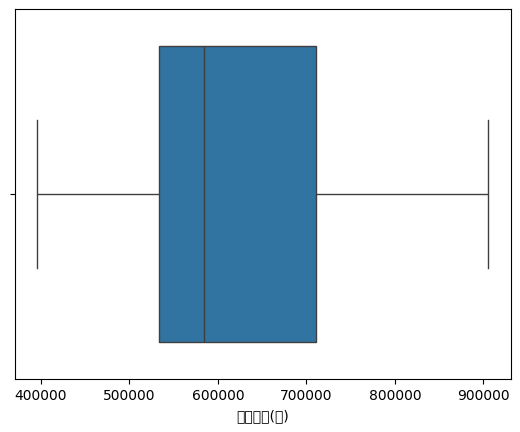

In [11]:
품목명 = '건고추'
raw_품목 = raw_data[raw_data['품목명'] == 품목명]
target_mask = conditions[품목명]['target'](raw_품목)
filtered_data = raw_품목[target_mask]

sns.boxplot(x = "평균가격(원)", data = filtered_data)
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

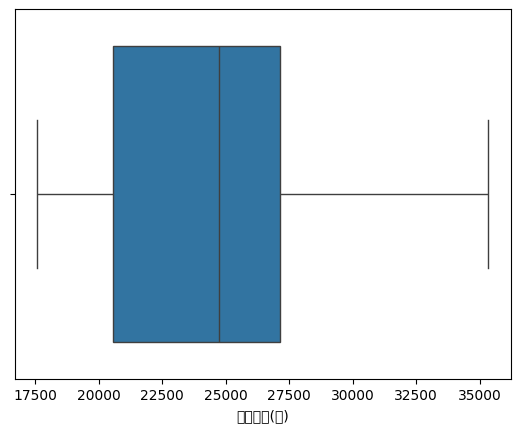

In [12]:
품목명 = '사과'
raw_품목 = raw_data[raw_data['품목명'] == 품목명]
target_mask = conditions[품목명]['target'](raw_품목)
filtered_data = raw_품목[target_mask]

sns.boxplot(x = "평균가격(원)", data = filtered_data)
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

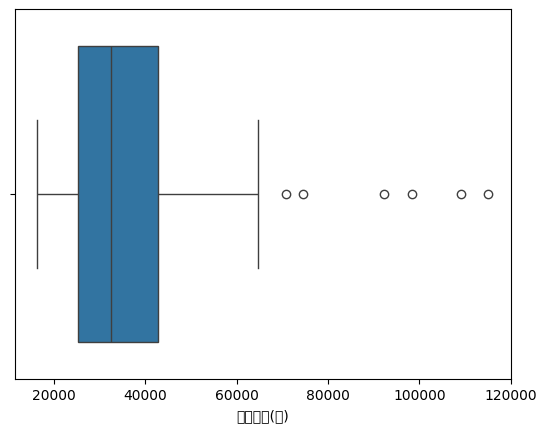

In [13]:
품목명 = '감자'
raw_품목 = raw_data[raw_data['품목명'] == 품목명]
target_mask = conditions[품목명]['target'](raw_품목)
filtered_data = raw_품목[target_mask]

sns.boxplot(x = "평균가격(원)", data = filtered_data)
plt.show()

In [14]:
filtered_data= filtered_data[filtered_data['평균가격(원)']<70000]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

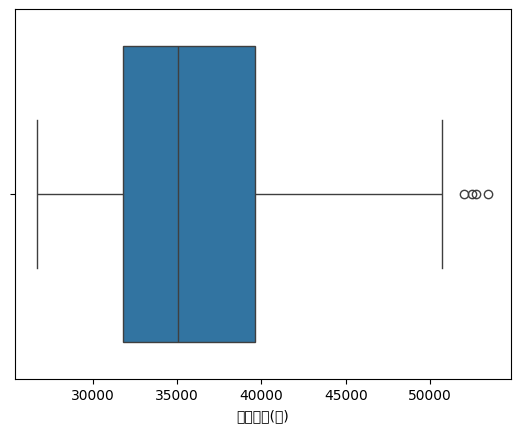

In [15]:
품목명 = '배'
raw_품목 = raw_data[raw_data['품목명'] == 품목명]
target_mask = conditions[품목명]['target'](raw_품목)
filtered_data = raw_품목[target_mask]

sns.boxplot(x = "평균가격(원)", data = filtered_data)
plt.show()

In [16]:
filtered_data= filtered_data[filtered_data['평균가격(원)']<55000]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

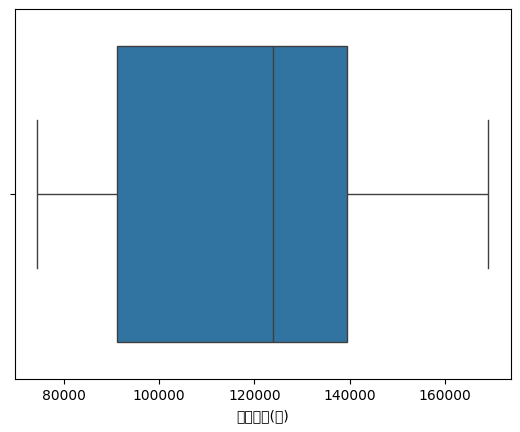

In [17]:
품목명 = '깐마늘(국산)'
raw_품목 = raw_data[raw_data['품목명'] == 품목명]
target_mask = conditions[품목명]['target'](raw_품목)
filtered_data = raw_품목[target_mask]

sns.boxplot(x = "평균가격(원)", data = filtered_data)
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

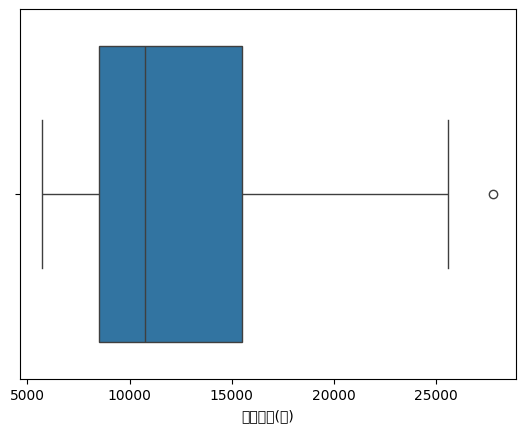

In [18]:
품목명 = '무'
raw_품목 = raw_data[raw_data['품목명'] == 품목명]
target_mask = conditions[품목명]['target'](raw_품목)
filtered_data = raw_품목[target_mask]

sns.boxplot(x = "평균가격(원)", data = filtered_data)
plt.show()

In [19]:
filtered_data= filtered_data[filtered_data['평균가격(원)']<27000]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

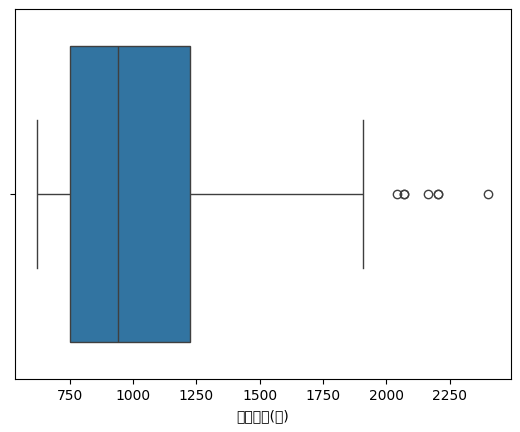

In [20]:
품목명 = '상추'
raw_품목 = raw_data[raw_data['품목명'] == 품목명]
target_mask = conditions[품목명]['target'](raw_품목)
filtered_data = raw_품목[target_mask]

sns.boxplot(x = "평균가격(원)", data = filtered_data)
plt.show()

In [21]:
filtered_data= filtered_data[filtered_data['평균가격(원)']<2000]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

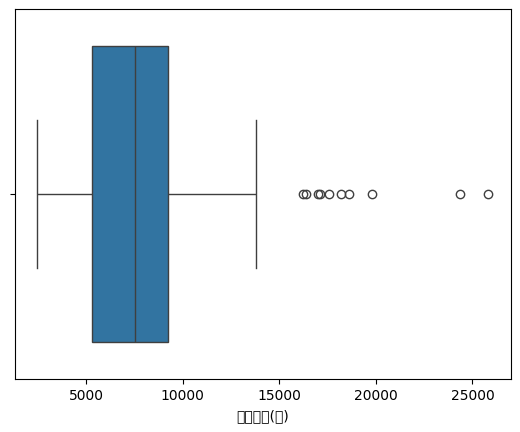

In [22]:
품목명 = '배추'
raw_품목 = raw_data[raw_data['품목명'] == 품목명]
target_mask = conditions[품목명]['target'](raw_품목)
filtered_data = raw_품목[target_mask]

sns.boxplot(x = "평균가격(원)", data = filtered_data)
plt.show()

In [23]:
filtered_data= filtered_data[filtered_data['평균가격(원)']<15000]

<Axes: xlabel='평균가격(원)'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLAB

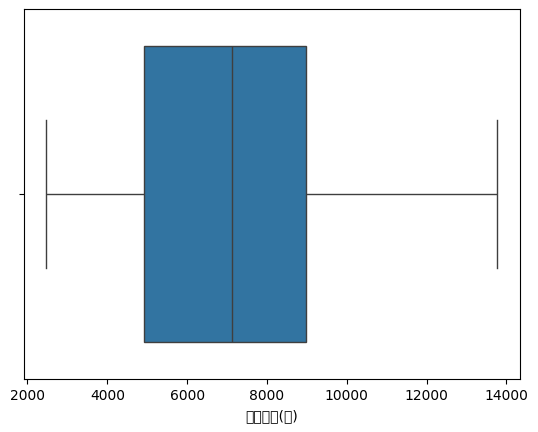

In [24]:
sns.boxplot(x = "평균가격(원)", data = filtered_data)

<Axes: xlabel='평균가격(원)'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLAB

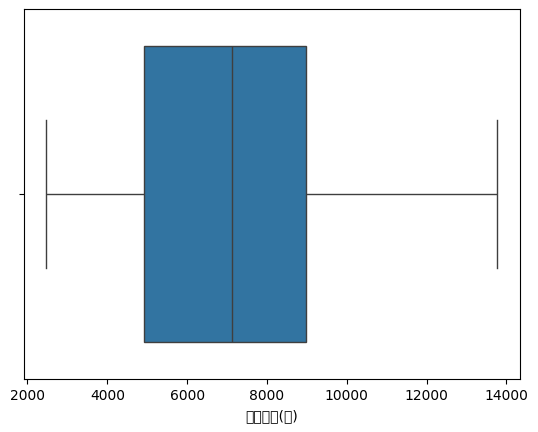

In [25]:
sns.boxplot(x = "평균가격(원)", data = filtered_data)

In [26]:
품목명 = '양파'
raw_품목 = raw_data[raw_data['품목명'] == 품목명]
target_mask = conditions[품목명]['target'](raw_품목)
filtered_data = raw_품목[target_mask]
print(filtered_data[filtered_data['평균가격(원)']<500])

             시점 품목명 품종명 거래단위 등급   평년 평균가격(원)     평균가격(원)
16609  201905중순  양파  양파  1키로  상   636.166667  488.625000
16610  201905하순  양파  양파  1키로  상   600.318519  498.500000
16611  201906상순  양파  양파  1키로  상   722.194444  464.500000
16612  201906중순  양파  양파  1키로  상   807.606481  397.666667
16613  201906하순  양파  양파  1키로  상   804.407407  449.625000
16614  201907상순  양파  양파  1키로  상   853.750000  389.888889
16615  201907중순  양파  양파  1키로  상   858.444444  413.000000
16616  201907하순  양파  양파  1키로  상   917.148148  426.666667
16619  201908하순  양파  양파  1키로  상   942.829630  473.500000
16620  201909상순  양파  양파  1키로  상   960.425926  495.625000
16622  201909하순  양파  양파  1키로  상   935.200000  494.000000
16623  201910상순  양파  양파  1키로  상  1016.271296  449.888889


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

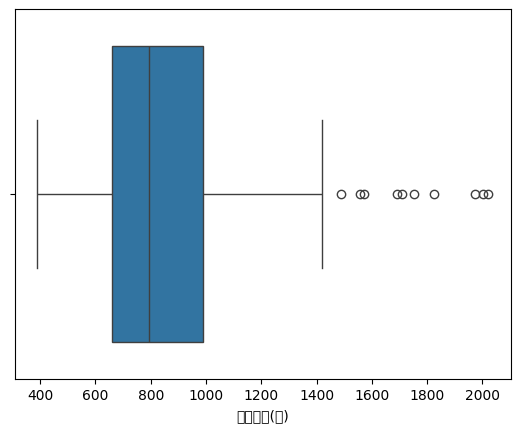

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x = "평균가격(원)", data = filtered_data)
#sns.distplot(x = '시점', y = "평균가격(원)", data = filtered_data)
plt.show()

In [28]:
filtered_data= filtered_data[filtered_data['평균가격(원)']<1600]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

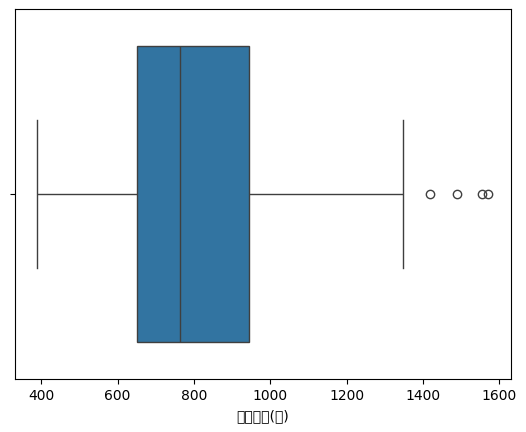

In [29]:
sns.boxplot(x = "평균가격(원)", data = filtered_data)
#sns.distplot(x = '시점', y = "평균가격(원)", data = filtered_data)
plt.show()

In [30]:
품목명 = '대파'
raw_품목 = raw_data[raw_data['품목명'] == 품목명]
target_mask = conditions[품목명]['target'](raw_품목)
filtered_data = raw_품목[target_mask]
print(filtered_data[filtered_data['평균가격(원)']<500])

Empty DataFrame
Columns: [시점, 품목명, 품종명, 거래단위, 등급, 평년 평균가격(원), 평균가격(원)]
Index: []


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

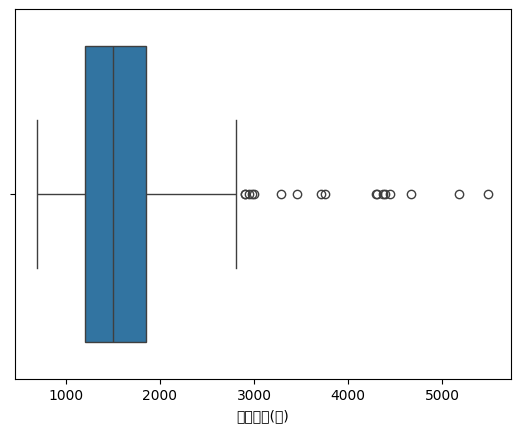

In [31]:
sns.boxplot(x = "평균가격(원)", data = filtered_data)
#sns.distplot(x = '시점', y = "평균가격(원)", data = filtered_data)
plt.show()

In [32]:
filtered_data= filtered_data[filtered_data['평균가격(원)']<2900]

In [33]:
def process_data(filtered_data, scaler=None):

    # 수치형 컬럼 처리
    numeric_columns = filtered_data.select_dtypes(include=[np.number]).columns
    filtered_data = filtered_data[['시점'] + list(numeric_columns)]
    filtered_data[numeric_columns] = filtered_data[numeric_columns].fillna(0)

    # 정규화 적용
    if scaler is None:
        scaler = MinMaxScaler()
        filtered_data[numeric_columns] = scaler.fit_transform(filtered_data[numeric_columns])
    else:
        filtered_data[numeric_columns] = scaler.transform(filtered_data[numeric_columns])

    return filtered_data, scaler

In [34]:
class AgriculturePriceDataset(Dataset):
    def __init__(self, dataframe, window_size=9, prediction_length=3, is_test=False):
        self.data = dataframe
        self.window_size = window_size
        self.prediction_length = prediction_length
        self.is_test = is_test

        self.price_column = '평균가격(원)'
        self.numeric_columns = self.data.select_dtypes(include=[np.number]).columns.tolist()

        self.sequences = []
        if not self.is_test:
            for i in range(len(self.data) - self.window_size - self.prediction_length + 1):
                x = self.data[self.numeric_columns].iloc[i:i+self.window_size].values
                y = self.data[self.price_column].iloc[i+self.window_size:i+self.window_size+self.prediction_length].values
                self.sequences.append((x, y))
        else:
            self.sequences = [self.data[self.numeric_columns].values]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        if not self.is_test:
            x, y = self.sequences[idx]
            return torch.FloatTensor(x), torch.FloatTensor(y)
        else:
            return torch.FloatTensor(self.sequences[idx])

In [35]:

class PricePredictionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PricePredictionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
    return total_loss / len(test_loader)

In [36]:
config = {
    "learning_rate": 2e-5,
    "epoch": 30,
    "batch_size": 64,
    "hidden_size": 64,
    "num_layers": 2,
    "output_size": 3
}

CFG = SimpleNamespace(**config)

In [38]:
품목별_predictions = {}
품목별_scalers = {}
data_path = filtered_data

pbar_outer = tqdm(품목_리스트, desc="품목 처리 중", position=0)
for 품목명 in pbar_outer:

    train_data, scaler = process_data(filtered_data[filtered_data['품목명'] == 품목명])

    품목별_scalers[품목명] = scaler
    dataset = AgriculturePriceDataset(train_data)

    # 데이터를 train과 validation으로 분할
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

    train_loader = DataLoader(train_data, CFG.batch_size, shuffle=True)
    val_loader = DataLoader(val_data, CFG.batch_size, shuffle=False)

    input_size = len(dataset.numeric_columns)

    model = PricePredictionLSTM(input_size, CFG.hidden_size, CFG.num_layers, CFG.output_size)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), CFG.learning_rate)

    best_val_loss = float('inf')
    os.makedirs('models', exist_ok=True)

    for epoch in range(CFG.epoch):
        train_loss = train_model(model, train_loader, criterion, optimizer, CFG.epoch)
        val_loss = evaluate_model(model, val_loader, criterion)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'models/best_model_{품목명}.pth')

        print(f'Epoch {epoch+1}/{CFG.epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    print(f'Best Validation Loss for {품목명}: {best_val_loss:.4f}')

    품목_predictions = []

    ### 추론
    pbar_inner = tqdm(range(25), desc="테스트 파일 추론 중", position=1, leave=False)
    for i in pbar_inner:
        test_file = data_path + f"/test/TEST_{i:02d}.csv"
        산지공판장_file = data_path +f"/test/meta/TEST_산지공판장_{i:02d}.csv"
        전국도매_file = data_path +f"/test/meta/TEST_전국도매_{i:02d}.csv"

        test_data, _ = process_data(test_file, 품목명, scaler=품목별_scalers[품목명])
        test_dataset = AgriculturePriceDataset(test_data, is_test=True)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_loader:
                output = model(batch)
                predictions.append(output.numpy())

        predictions_array = np.concatenate(predictions)

        # 예측값을 원래 스케일로 복원
        price_column_index = test_data.columns.get_loc(test_dataset.price_column)
        predictions_reshaped = predictions_array.reshape(-1, 1)

        # 가격 열에 대해서만 inverse_transform 적용
        price_scaler = MinMaxScaler()
        price_scaler.min_ = 품목별_scalers[품목명].min_[price_column_index]
        price_scaler.scale_ = 품목별_scalers[품목명].scale_[price_column_index]
        predictions_original_scale = price_scaler.inverse_transform(predictions_reshaped)
        #print(predictions_original_scale)

        if np.isnan(predictions_original_scale).any():
            pbar_inner.set_postfix({"상태": "NaN"})
        else:
            pbar_inner.set_postfix({"상태": "정상"})
            품목_predictions.extend(predictions_original_scale.flatten())


    품목별_predictions[품목명] = 품목_predictions
    pbar_outer.update(1)


품목 처리 중:   0%|          | 0/10 [00:00<?, ?it/s]

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by MinMaxScaler.

In [ ]:
품목별_predictions = {}
품목별_scalers = {}
data_path = '/content/drive/MyDrive/SAI/Project/농산물/data_1001'

pbar_outer = tqdm(품목_리스트, desc="품목 처리 중", position=0)
for 품목명 in pbar_outer:
    # Check if the filtered DataFrame is empty and skip if it is.
    if filtered_data[filtered_data['품목명'] == 품목명].empty:
        print(f"{품목명} is empty. Skipping...")
        continue

    train_data, scaler = process_data(filtered_data[filtered_data['품목명'] == 품목명])

    품목별_scalers[품목명] = scaler
    dataset = AgriculturePriceDataset(train_data)

    # 데이터를 train과 validation으로 분할
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

    train_loader = DataLoader(train_data, CFG.batch_size, shuffle=True)
    val_loader = DataLoader(val_data, CFG.batch_size, shuffle=False)

    input_size = len(dataset.numeric_columns)

    model = PricePredictionLSTM(input_size, CFG.hidden_size, CFG.num_layers, CFG.output_size)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), CFG.learning_rate)

    best_val_loss = float('inf')
    os.makedirs('models', exist_ok=True)

    for epoch in range(CFG.epoch):
        train_loss = train_model(model, train_loader, criterion, optimizer, CFG.epoch)
        val_loss = evaluate_model(model, val_loader, criterion)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'models/best_model_{품목명}.pth')

        print(f'Epoch {epoch+1}/{CFG.epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    print(f'Best Validation Loss for {품목명}: {best_val_loss:.4f}')

    품목_predictions = []

    ### 추론
    pbar_inner = tqdm(range(25), desc="테스트 파일 추론 중", position=1, leave=False)
    for i in pbar_inner:
        test_file = data_path + f"/test/TEST_{i:02d}.csv"

        if test_file[test_file['품목명'] == 품목명].empty:
            print(f"{품목명} is empty. Skipping...")
            continue

        train_data, scaler = process_data(filtered_data[filtered_data['품목명'] == 품목명])
        test_dataset = AgriculturePriceDataset(test_data, is_test=True)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_loader:
                output = model(batch)
                predictions.append(output.numpy())

        predictions_array = np.concatenate(predictions)

        # 예측값을 원래 스케일로 복원
        price_column_index = test_data.columns.get_loc(test_dataset.price_column)
        predictions_reshaped = predictions_array.reshape(-1, 1)

        # 가격 열에 대해서만 inverse_transform 적용
        price_scaler = MinMaxScaler()
        price_scaler.min_ = 품목별_scalers[품목명].min_[price_column_index]
        price_scaler.scale_ = 품목별_scalers[품목명].scale_[price_column_index]
        predictions_original_scale = price_scaler.inverse_transform(predictions_reshaped)
        #print(predictions_original_scale)

        if np.isnan(predictions_original_scale).any():
            pbar_inner.set_postfix({"상태": "NaN"})
        else:
            pbar_inner.set_postfix({"상태": "정상"})
            품목_predictions.extend(predictions_original_scale.flatten())


    품목별_predictions[품목명] = 품목_predictions
    pbar_outer.update(1)